## Havza Algoritması
- [Watershed Algoritması ile Görüntü Segmentasyonu](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)
- [GÖRÜNTÜ SEGMENTASYONU VE MATEMATİKSEL MORFOLOJİ](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html)
<br>

__[link text](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html)__
`string`
[WaterShed Algoritmasına Sahip Özel Tohumlar](#Custom-Seeds-with-the-WaterShed-Algorithm)
[Bölüm başlığı](#section_ID)



<div class="alert alert-block alert-info">
<b>Tiyo:</b> İpuçları ve notlar için mavi kutuları (uyarı bilgileri) kullanın.
Eğer bu bir not ise “Not” kelimesini eklemenize gerek yoktur.
</div>

<div class="alert alert-block alert-warning">
<b>Örnek:</b> Olmayan örnekler için sarı kutuları kullanın.
kod hücrelerinin içinde veya gerekirse matematiksel formüller için kullanın.
</div>

<div class="alert alert-block alert-success">
<b>Size kalmış:</b> Yeşil kutuları dikkatli ve yalnızca belirli amaçlar için kullanın
diğer kutuların kapsayamayacağı bir amaç. Örneğin, eğer çok şeyiniz varsa
bağlantı verilecek ilgili içerik varsa, belki de yeşil kutuları kullanmaya karar verebilirsiniz.
bir not defterinin her bölümünden ilgili bağlantılar.
</div>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
img = cv2.imread('/content/water_coins.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

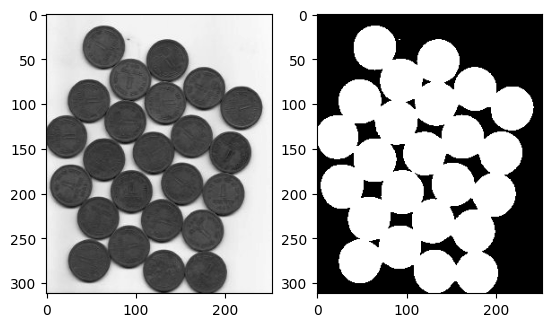

In [3]:
plt.subplot(1,2,1)
plt.imshow(gray,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(thresh,cmap='gray')

In [4]:
# gürültü giderme
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# emin arka plan alanı
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Kesin ön plan alanını bulma
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Bilinmeyen bölgeyi bulma
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


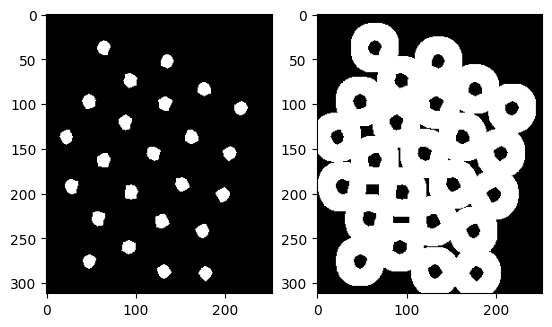

In [5]:
plt.subplot(1,2,1)
plt.imshow(sure_fg,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(unknown,cmap='gray')

In [6]:
# İşaretleyici etiketleme
ret, markers = cv2.connectedComponents(sure_fg)
# Arka planın 0 değil 1 olması için tüm etiketlere bir tane ekleyin
markers = markers+1
# Şimdi bilinmeyen bölgeyi sıfırla işaretleyin
markers[unknown==255] = 0

25


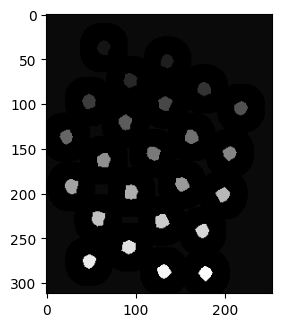

In [7]:
plt.subplot(1,2,1)
plt.imshow(markers,cmap='gray')
print(ret)

<a id="section_ID"></a>

In [8]:
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

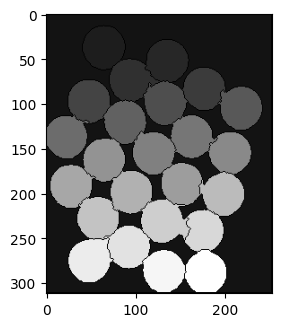

In [9]:
plt.subplot(1,2,1)
plt.imshow(markers,cmap='gray')

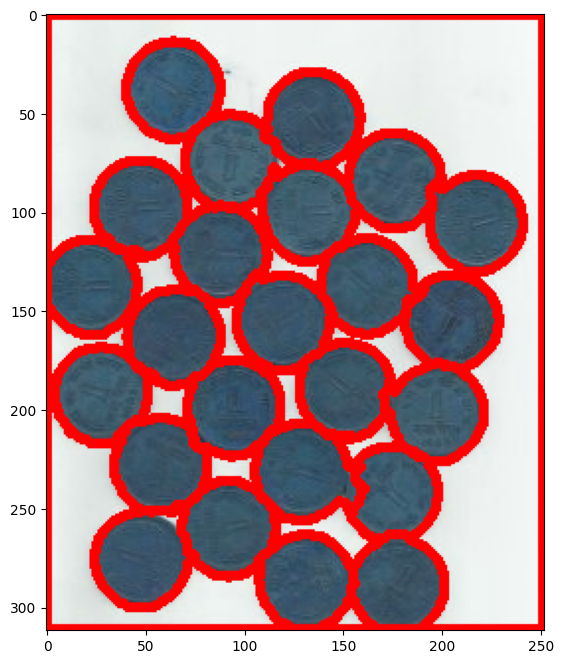

In [10]:
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# Konturlardaki her giriş için
for i in range(len(contours)):

    # dizideki son sütun, eğer harici bir kontur varsa -1'dir (içinde kontur yok)
    if hierarchy[0][i][3] == -1:

        # Artık dış konturları kontur listesinden çizebiliriz
        cv2.drawContours(img, contours, i, (255, 0, 0), 2)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.imshow(img)

## WaterShed Algoritmasına Sahip Özel Kaynak

Rengi ayarlamak için 0-9


In [11]:
road = cv2.imread('/content/road_image.jpg')
road_copy = np.copy(road)
# Sonuçların çizilmesi için boş alan oluşturun
marker_image = np.zeros(road.shape[:2],dtype=np.int32)
segments = np.zeros(road.shape,dtype=np.uint8)

### İşaretçiler için renkler oluşturun

https://matplotlib.org/examples/color/colormaps_reference.html

In [12]:
from matplotlib import cm

In [13]:
# (R,G,B,Alpha) döndürür, yalnızca RGB değerlerine ihtiyacımız var
def create_rgb(i):
    x = np.array(cm.tab10(i))[:3]*255
    return tuple(x)

In [14]:
colors = []
# Her rakam için bir renk
for i in range(10):
    colors.append(create_rgb(i))
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [15]:
# 0-9 arası sayılar
n_markers = 10
# Varsayılan ayarları
current_marker = 1
marks_updated = False

In [16]:
def mouse_callback(event, x, y, flags, param):
    global marks_updated

    if event == cv2.EVENT_LBUTTONDOWN:

        # İŞARETLEYİCİLER İÇİN TAKİP
        cv2.circle(marker_image, (x, y), 10, (current_marker), -1)

        # KULLANICI GÖRÜNTÜSÜNDE EKRAN
        cv2.circle(road_copy, (x, y), 10, colors[current_marker], -1)
        marks_updated = True


In [ ]:
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)

while True:

    # 2 pencere göster
    cv2.imshow('WaterShed Segments', segments)
    cv2.imshow('Road Image', road_copy)


    # Esc tuşuna basıldığında her şeyi kapat
    k = cv2.waitKey(1)

    if k == 27:
        break

    # Tüm renkleri temizleyin ve 'c'ye basıldığında baştan başlayın
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[0:2], dtype=np.int32)
        segments = np.zeros(road.shape,dtype=np.uint8)

    # 0-9 arası bir sayı seçilirse rengi indeksleyin
    elif k > 0 and chr(k).isdigit():
        # chr yazdırılabilir rakama dönüşür

        current_marker  = int(chr(k))

        # KULLANICININ DİKKATSİZ OLMASI DURUMUNDA KONTROL EDİLECEK KOD
#         n = int(chr(k))
#         if 1 <= n <= n_markers:
#             current_marker = n

    # Bir yere tıklarsak, seçtiğimiz işaretçilerdeki dönüm noktası algoritmasını çağırın
    if marks_updated:

        marker_image_copy = marker_image.copy()
        cv2.watershed(road, marker_image_copy)

        segments = np.zeros(road.shape,dtype=np.uint8)

        for color_ind in range(n_markers):
            segments[marker_image_copy == (color_ind)] = colors[color_ind]

        marks_updated = False

cv2.destroyAllWindows()
plt.imshow(segments)